In [1]:
import argparse
import numpy as np
import os
import re
import sys
import time
from osgeo import gdal, osr
from collections import defaultdict
from supres import DSen2_20, DSen2_60, Solver

from mlib import *
from tqdm import tqdm_notebook as tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

ImportError: libiconv.so.2: cannot open shared object file: No such file or directory

In [4]:
for idx in range(10):
    with open('error_log.txt', 'a+') as f:
        f.write(str(idx)+'\n')

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Define Classes and Processing Functions

In [2]:
class BigEarthReader():
    def __init__(self, root):
        self.root = root

        # Checks the existence of required python packages
        self.gdal_existed = self.rasterio_existed = self.georasters_existed = False
        try:
            from osgeo import gdal
            self.gdal_existed = True
            print('INFO: GDAL package will be used to read GeoTIFF files')
        except ImportError:
            try:
                import rasterio
                self.rasterio_existed = True
                print('INFO: rasterio package will be used to read GeoTIFF files')
            except ImportError:
                print('ERROR: please install either GDAL or rasterio package to read GeoTIFF files')

        # Spectral band names to read related GeoTIFF files
        self.band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 
                           'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

    def reset_root(self, root):
        self.root = root

    def check_bands(self, patch_name):
        self._read(patch_name, ret=False)

    def read_file(self, patch_name):
        return self._read(patch_name, ret=True)

    def _read(self, patch_name, ret=False):
        # Reads spectral bands of all patches whose folder names are populated before
        bands = []
        for band_name in self.band_names:
            # First finds related GeoTIFF path and reads values as an array
            band_path = os.path.join(
                self.root, patch_name, patch_name + '_' + band_name + '.tif')
            if self.gdal_existed:
                band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
                raster_band = band_ds.GetRasterBand(1)
                band_data = raster_band.ReadAsArray()
            elif self.rasterio_existed:
                band_ds = rasterio.open(band_path)
                band_data = band_ds.read(1)
            if ret:
                bands.append(band_data)
            else:
                # band_data keeps the values of band band_name for the patch patch_name
                print('INFO: band', band_name, 'of patch', patch_name,
                        'is ready with size', band_data.shape)
        if ret:
            return bands

def split_bands(bands):
    d10 = np.array([bands[i] for i in (1,2,3,7)])
    d20 = np.array([bands[i] for i in (4,5,6,8,10,11)])
    d60 = np.array([bands[i] for i in (0,9)])
    return d10.transpose(1,2,0), d20.transpose(1,2,0), d60.transpose(1,2,0)

def ssr(name, breader):
    raster = breader.read_file(name)
    d10, d20, d60 = split_bands(raster)
    sr20 = DSen2_20(d10, d20, deep=False)
    sr60 = DSen2_60(d10, d20, d60, deep=False)
    output = np.vstack((d10.transpose(2,0,1), sr20.transpose(2,0,1), sr60.transpose(2,0,1)))
    output = output[(10,0,1,2,4,5,6,3,7,11,8,9),:,:]
    return output

In [3]:
breader = BigEarthReader(r'/media/miracle/AICO/Satellite/BigEarthNet-v1.0')

INFO: GDAL package will be used to read GeoTIFF files


# Test for Scripts

In [4]:
raster = breader.read_file('S2A_MSIL2A_20170613T101031_31_57')
d10, d20, d60 = split_bands(raster)
print(d10.shape)
print(d20.shape)
print(d60.shape)

(120, 120, 4)
(60, 60, 6)
(20, 20, 2)


In [5]:
solver = Solver()

In [7]:
sr20 = solver.predict20(d10, d20)
sr60 = solver.predict60(d10, d20, d60)

1/1 [==============================] - 0s 658us/step
(6, 120, 120)
1/1 [==============================] - 0s 648us/step
(2, 120, 120)


In [5]:
sr20 = DSen2_20(d10, d20, deep=False)
sr60 = DSen2_60(d10, d20, d60, deep=False)

Symbolic Model Created.
Predicting using file: ../models/s2_032_lr_1e-04.hdf5
1/1 [==============================] - 0s 900us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_030_lr_1e-05.hdf5
1/1 [==============================] - 0s 523us/step
(2, 120, 120)


In [13]:
type(d10)

numpy.ndarray

In [7]:
out_root = r'L:\Satellite\SRBigEarth'

name = 'S2A_MSIL2A_20170613T101031_25_48'
result = ssr(name, breader)
mio.write(result, Path(out_root)/f'{name}.npy')

Symbolic Model Created.
Predicting using file: ../models/s2_032_lr_1e-04.hdf5
1/1 [==============================] - 0s 556us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_030_lr_1e-05.hdf5
1/1 [==============================] - 0s 708us/step
(2, 120, 120)


In [8]:
import pandas

In [6]:
# mload = mio.read(Path(out_root)/f'{name}.npy')

filename = '/media/miracle/AICO/Satellite/SRBigEarth/S2B_MSIL2A_20180525T94031_4_19.npy'
mload = mio.read(filename)

for i in range(len(mload)):
    plt.figure()
    plt.imshow(mload[i])

# Batch Processing for all pairs

In [6]:
ori_dir = Path(breader.root)
folders = glob.glob(breader.root+'/*')

In [7]:
print(len(folders))

590326


In [9]:
out_root = r'/media/miracle/AICO/Satellite/SRBigEarth'

with Timer("100 Pairs"):
    for folder in tqdm(folders[0:100]):
        name = Path(folder).name
        result = ssr(name, breader)
        mio.write(result, Path(out_root)/f'{name}.npy')

/home/miracle/anaconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100 [00:00<?, ?it/s]

lr_1e-04.hdf5
1/1 [==============================] - 0s 640us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_030_lr_1e-05.hdf5
1/1 [==============================] - 0s 676us/step
(2, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_032_lr_1e-04.hdf5
1/1 [==============================] - 0s 545us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_030_lr_1e-05.hdf5
1/1 [==============================] - 0s 551us/step
(2, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_032_lr_1e-04.hdf5
1/1 [==============================] - 0s 555us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_030_lr_1e-05.hdf5
1/1 [==============================] - 0s 546us/step
(2, 120, 120)
Symbolic Model Created.
Predicting using file: ../models/s2_032_lr_1e-04.hdf5
1/1 [==============================] - 0s 553us/step
(6, 120, 120)
Symbolic Model Created.
Predicting using file: ..

# Try direct Tar Work

In [31]:
import tarfile

# tar = tarfile.open(r"L:\Satellite\BigEarthNet-S2-v1.0.tar.gz")
tar = tarfile.open(r'L:\Satellite\test.tar')
tar.getmembers()
with tar.extractfile('test/test01/test.txt') as f:
    print(f.readlines())

In [ ]:
def read_sent(patch_name, ret=False):
    root = 'test'
    band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 
                'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

    # Reads spectral bands of all patches whose folder names are populated before
    bands = []
    for band_name in band_names:
        # First finds related GeoTIFF path and reads values as an array
        band_path = os.path.join(
            root, patch_name, patch_name + '_' + band_name + '.tif')
        print(band_path)
        band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
        raster_band = band_ds.GetRasterBand(1)
        band_data = raster_band.ReadAsArray()
        # elif self.rasterio_existed:
        #     band_ds = rasterio.open(band_path)
        #     band_data = band_ds.read(1)
        if ret:
            bands.append(band_data)

# Downsample

In [1]:
sr_root = r'/media/miracle/AICO/Satellite/SRBigEarth'
lr_root = pf.get_folder(r'/media/miracle/AICO/Satellite/LRBigEarth')
sr_paths = glob.glob(sr_root+r'\*.npy')
print(f'Pairs:{len(sr_paths)}')

NameError: name 'pf' is not defined

In [ ]:
for sr_path in sr_paths:
    name = Path(sr_path).name
    sr = mio.read(sr_path)
    lr = cv2.resize(sr.transpose(1,2,0),None,fx=0.5,fy=0.5).transpose(2,0,1)
    mio.dump(lr, Path(lr_root,name))

In [ ]:
name = Path(sr_paths[0]).name
sr = mio.read(sr_paths[0])
print(sr.shape)
lr = cv2.resize(sr.transpose(1,2,0),None,fx=0.5,fy=0.5).transpose(2,0,1)
print(lr.shape)

In [ ]:
mio.dump(lr, Path(lr_root,name))

In [ ]:
rel = mio.load(Path(lr_root,name))
for i in range(rel.shape[0]):
    plt.figure()
    plt.imshow(rel[i])

(120, 120, 4)
(60, 60, 6)
(120, 120, 6)
(20, 20, 2)
(120, 120, 2)


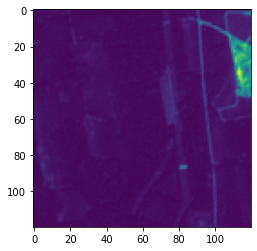

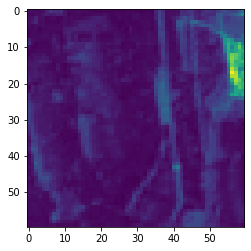

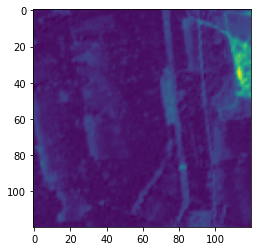

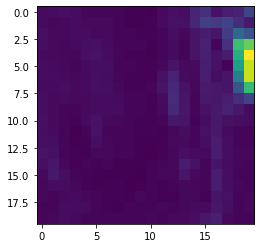

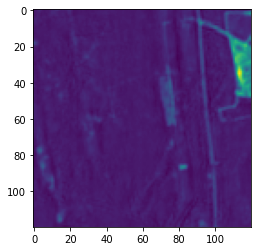

In [13]:
print(d10.shape)
plt.figure()
plt.imshow(d10[:,:,0])

print(d20.shape)
plt.figure()
plt.imshow(d20[:,:,0])

print(sr20.shape)
plt.figure()
plt.imshow(sr20[:,:,0])

print(d60.shape)
plt.figure()
plt.imshow(d60[:,:,0])

print(sr60.shape)
plt.figure()
plt.imshow(sr60[:,:,0])

In [14]:
patch_folder_path=r'L:\Satellite\BigEarthNet-v1.0\S2A_MSIL2A_20170613T101031_31_57'
# Spectral band names to read related GeoTIFF files
band_names = ['B01', 'B02', 'B03', 'B04', 'B05',
              'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

# Reads spectral bands of all patches whose folder names are populated before
patch_name = os.path.basename(patch_folder_path)
for band_name in band_names:
    # First finds related GeoTIFF path and reads values as an array
    band_path = os.path.join(
        patch_folder_path, patch_name + '_' + band_name + '.tif')
    if gdal_existed:
        band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
        raster_band = band_ds.GetRasterBand(1)
        band_data = raster_band.ReadAsArray()
    elif rasterio_existed:
        band_ds = rasterio.open(band_path)
        band_data = band_ds.read(1)
    # band_data keeps the values of band band_name for the patch patch_name
    print('INFO: band', band_name, 'of patch', patch_name,
            'is ready with size', band_data.shape)

INFO: band B01 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (20, 20)
INFO: band B02 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (120, 120)
INFO: band B03 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (120, 120)
INFO: band B04 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (120, 120)
INFO: band B05 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (60, 60)
INFO: band B06 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (60, 60)
INFO: band B07 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (60, 60)
INFO: band B08 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (120, 120)
INFO: band B8A of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (60, 60)
INFO: band B09 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (20, 20)
INFO: band B11 of patch S2A_MSIL2A_20170613T101031_0_59 is ready with size (60, 60)
INFO: band B12 of patch S2A_MSIL2A_20170613T101031_0_59 is ready wit

In [8]:
raster = gdal.Open(data_file)